In [57]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from data.data import InvERTDataset
from model.models import UNet
from json5 import load as json_load
import cv2

In [58]:
with open("/mnt/ensg/tout_le_monde/Basile/PEGGHy/PEGGHy_20mars2025.Dat", "r", encoding='utf8') as datafile:
    lines = datafile.readlines()

In [59]:
datalines = lines[9:-4]
print(datalines[0].strip())
print(datalines[-1].strip())

num_electrodes = 48

4  0.00  0.00 3.00  0.00 1.00  0.00 2.00  0.00 19.07
4  44.00  0.00 47.00  0.00 45.00  0.00 46.00  0.00 324.33


In [60]:
a = int(0.00)

In [61]:
pseudosection = np.zeros((48 // 2 - 1, 48 - 3))
rho_apps = []
for i, line in enumerate(datalines):
    line = line.strip().split()
    A, B, M, N = int(float(line[1])), int(float(line[3])), int(float(line[5])), int(float(line[7]))
    rhoapp = float(line[9])
    row = (B - A) // 2 - 1
    col = M - 1
    if np.random.random() < 0.0:
        pseudosection[row, col] = 1
    else:
        pseudosection[row, col] = rhoapp
    rho_apps.append(rhoapp)

mean_rhoapp = np.mean(rho_apps)
for i in range(48 // 2 - 1):
    for j in range(i, 48 - 3 - i):
        if pseudosection[i, j] == 0:
            pseudosection[i, j] = 1
            # pseudosection[i, j] = pseudosection[i - 1, j]

pseudosection[pseudosection == 0] = np.nan

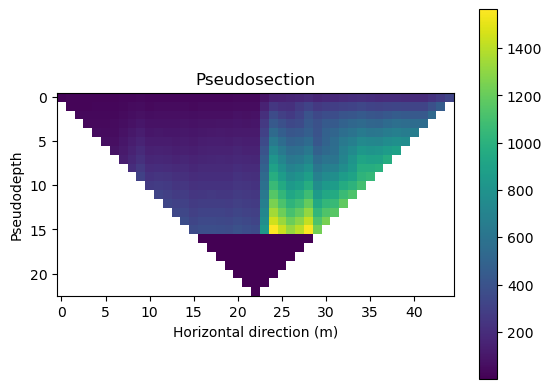

In [62]:
plt.imshow(pseudosection, cmap="viridis")
plt.colorbar()
plt.title("Pseudosection")
plt.xlabel("Horizontal direction (m)")
plt.ylabel("Pseudodepth")
plt.show()

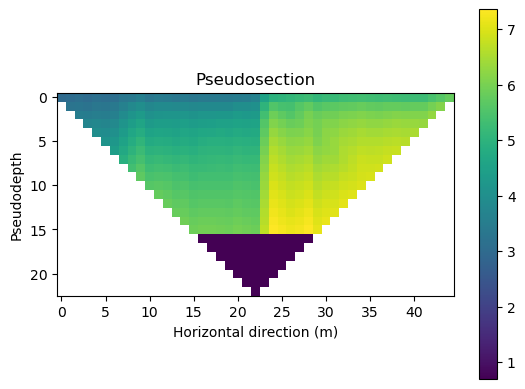

In [63]:
pseudosection = np.log1p(pseudosection)
plt.imshow(pseudosection, cmap="viridis")
plt.colorbar()
plt.title("Pseudosection")
plt.xlabel("Horizontal direction (m)")
plt.ylabel("Pseudodepth")
plt.show()

In [64]:
with open("/mnt/ensg/tout_le_monde/Basile/dataset_sensitivity_5_5_cosine_tape/overall_statistics.txt", "r", encoding='utf8') as minmaxfile:
    lines = minmaxfile.readlines()
min_dataset = float(eval(lines[-1].strip().split()[3].strip(',')))
max_dataset = float(eval(lines[-1].strip().split()[5].strip('}')))
print(min_dataset)
print(max_dataset)

0.0
10.673124313354492


In [65]:

px_to_m = 1

num_electrodes = 48
electrode_spacing_true = 1
true_survey_length_m = (num_electrodes - 1) * electrode_spacing_true
print(f"True length of the survey: {true_survey_length_m} m")

electrode_spacing = 5
total_padding = electrode_spacing * 5 * 2
W = (num_electrodes - 1) * electrode_spacing + total_padding
print(f"Width of the resistivity model: {W} PX")

L_T = W - total_padding
print(f"Length of the survey in the resistivity model: {L_T} PX")

m_per_PX = true_survey_length_m / L_T
print(f"Meters per PIXELs: {m_per_PX} m/PX")

px_per_PX = m_per_PX

w = W * px_per_PX
print(f"Width of the resistivity model: {w} m")

subsection_length = w

True length of the survey: 47 m
Width of the resistivity model: 285 PX
Length of the survey in the resistivity model: 235 PX
Meters per PIXELs: 0.2 m/PX
Width of the resistivity model: 57.0 m


Width of the survey: 0.1875 normalized


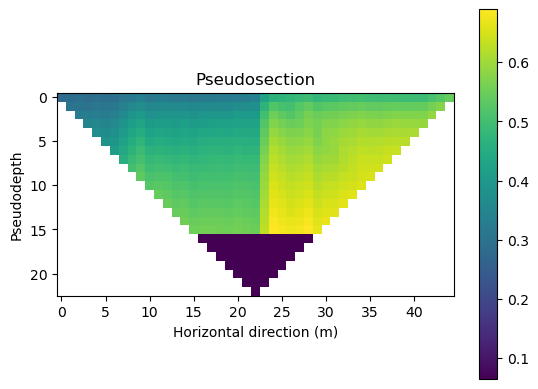

In [66]:
pseudosection = pseudosection - min_dataset
pseudosection = pseudosection / (max_dataset - min_dataset)

num_electrodes = (48 - 24) / (96 - 24)
subsection_length = (subsection_length - 24) / (200 - 24)
print(f"Width of the survey: {subsection_length} normalized")

plt.imshow(pseudosection, cmap="viridis")
plt.colorbar()
plt.title("Pseudosection")
plt.xlabel("Horizontal direction (m)")
plt.ylabel("Pseudodepth")
plt.show()

pseudosection[np.isnan(pseudosection)] = 0

In [67]:
# pseudosection = cv2.resize(pseudosection, (93, 49), interpolation=cv2.INTER_LINEAR)
# pseudosection[np.isnan(pseudosection)] = 0
# plt.imshow(pseudosection, cmap="viridis")
# plt.colorbar()
# plt.title("Pseudosection")
# plt.xlabel("Horizontal direction (m)")
# plt.ylabel("Pseudodepth")
# plt.show()

In [68]:
# experiment_path = Path("/home/labo3A/results/no_pad_no_resize_sum_weight_06-05-2025_08h07")
experiment_path = Path("/mnt/ensg/tout_le_monde/Basile/results/no_pad_no_resize_sum_weight_06-05-2025_08h07")

model_ckpt_path = experiment_path / "figures/model_output/checkpoints"
model_ckpt_list = sorted(model_ckpt_path.glob("model_epoch*.pth"), key=lambda x: int(x.stem.split("_")[-1]))
print(f"Found {len(model_ckpt_list)} checkpoints, last one is {model_ckpt_list[-1].stem}")
model = UNet()
model.load_state_dict(torch.load(model_ckpt_list[-1], map_location='cpu')['model_state_dict'])
model.eval()

Found 30 checkpoints, last one is model_epoch_30


UNet(
  (downs): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (5): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (1): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): InstanceNor

In [69]:
true_pseudosection = torch.from_numpy(pseudosection.astype(np.float32))
print(true_pseudosection)
print(true_pseudosection.shape)

true_pseudosection = true_pseudosection.unsqueeze(0)
num_electrode_channel = torch.ones_like(true_pseudosection) * num_electrodes
subsection_length_channel = torch.ones_like(true_pseudosection) * subsection_length
wa_array_type_channel = torch.zeros_like(true_pseudosection)
slm_array_type_channel = torch.ones_like(true_pseudosection)
true_pseudosection = torch.cat((true_pseudosection, num_electrode_channel, subsection_length_channel, wa_array_type_channel, slm_array_type_channel), dim=0)
# norm_log_resistivity_model = torch.zeros((192, 256))
norm_log_resistivity_model = torch.zeros((213, 285))

true_pseudosection = true_pseudosection.unsqueeze(0)
norm_log_resistivity_model = norm_log_resistivity_model.unsqueeze(0).unsqueeze(0)

print(true_pseudosection.shape)
print(norm_log_resistivity_model.shape)


tensor([[0.2810, 0.2856, 0.2920,  ..., 0.5097, 0.5244, 0.5420],
        [0.0000, 0.3041, 0.3066,  ..., 0.5576, 0.5744, 0.0000],
        [0.0000, 0.0000, 0.3291,  ..., 0.5881, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
torch.Size([23, 45])
torch.Size([1, 5, 23, 45])
torch.Size([1, 1, 213, 285])


In [70]:
output = model(true_pseudosection, norm_log_resistivity_model)

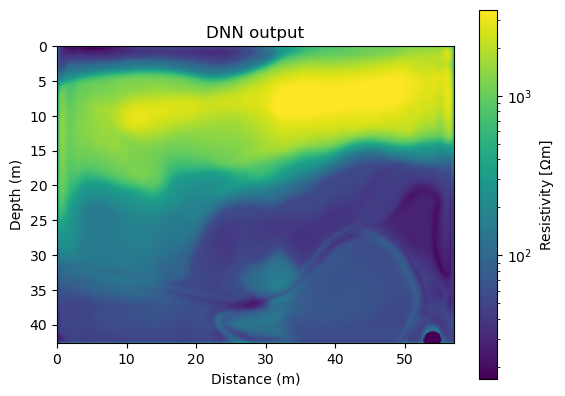

In [91]:
def detransform(log_res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return np.exp(log_res * np.log(50000)).astype(log_res.dtype)
ou = detransform(output[0, 0].detach().numpy())
vmax = 3481.7021
vmin = 16.65965
from matplotlib.colors import LogNorm
norm = LogNorm(vmin=vmin, vmax=vmax)
plt.imshow(detransform(output[0, 0].detach().numpy()), cmap="viridis", extent=[0, 57, 213 / 5, 0], norm=norm)
clb = plt.colorbar()
clb.set_label(r"Resistivity [$\Omega$m]")
plt.title("DNN output")
plt.xlabel("Distance (m)")
plt.ylabel("Depth (m)")
plt.show()

In [72]:
num_e = int(num_electrodes * (96 - 24) + 24)

inter_electrode_distance = 5
inter_electrode_distance_m = 1
total_padding = 2 * 5 * inter_electrode_distance
W = int((num_e - 1) * inter_electrode_distance + total_padding)

true_sruvey_l = (num_e - 1) * inter_electrode_distance_m

print(f"Width of the resistivity model: {W} pixels")

px_to_m = true_sruvey_l / (W - total_padding)
print(f"Pixel to meter ratio: {px_to_m} m/pixel")

W_m = int(W * px_to_m)
print(f"Width of the resistivity model in meters: {W_m} m")

normalized_subsection_length = (W_m - 24) / (200 - 24)
print(f"Normalized subsection length: {normalized_subsection_length}")

Width of the resistivity model: 285 pixels
Pixel to meter ratio: 0.2 m/pixel
Width of the resistivity model in meters: 57 m
Normalized subsection length: 0.1875


(213, 285)
213
Horizontal length in meters: 57 m
Depth to pixel: 25 pixels
[ 25  30  35  40  45  50  55  60  65  70  75  80  85  90  95 100 105 110
 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200
 205 210 215 220 225 230 235 240 245 250 255 260]


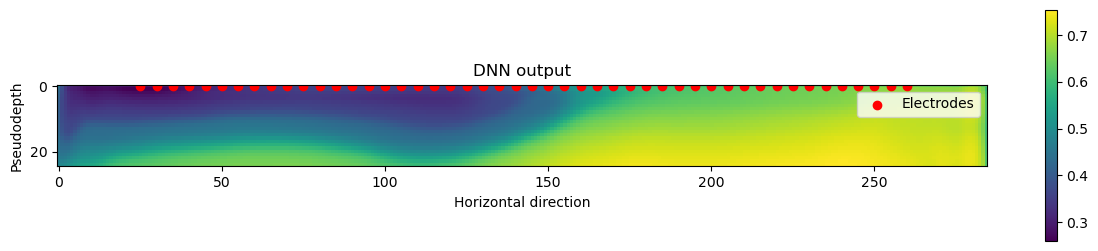

In [79]:
output_np = output[0, 0].detach().numpy()
print(output_np.shape)
# true_dims = cv2.resize(output_np, (255, 191), interpolation=cv2.INTER_LINEAR)
output_to_show = output_np[:]
print(len(output_to_show))
horizontal_length_m = 1 * W_m
print(f"Horizontal length in meters: {horizontal_length_m} m")
vertical_length_m = int(horizontal_length_m * 0.75)

depth_m = 5
# depth_to_pixel = depth_m * int((0.75 * W) / int(w * 0.75))
depth_to_pixel = int(depth_m * 213 / 42)
# depth_to_pixel = int(depth_m * 0.75 * W / 150)
print(f"Depth to pixel: {depth_to_pixel} pixels")

x_elec = np.arange(25, W - 25 + 1, 5)
print(x_elec)
y_elec = [0 for _ in range(len(x_elec))]
plt.figure(figsize=(15, 3))
plt.scatter(x_elec, y_elec, c="red", marker="o", label="Electrodes")
plt.imshow(output_to_show[:depth_to_pixel], cmap="viridis")
plt.colorbar()
plt.title("DNN output")
plt.xlabel("Horizontal direction")
plt.ylabel("Pseudodepth")
plt.legend()
plt.show()

In [80]:
def detransform(log_res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return np.exp(log_res * np.log(50000)).astype(log_res.dtype)

o = detransform(output_to_show[:depth_to_pixel])

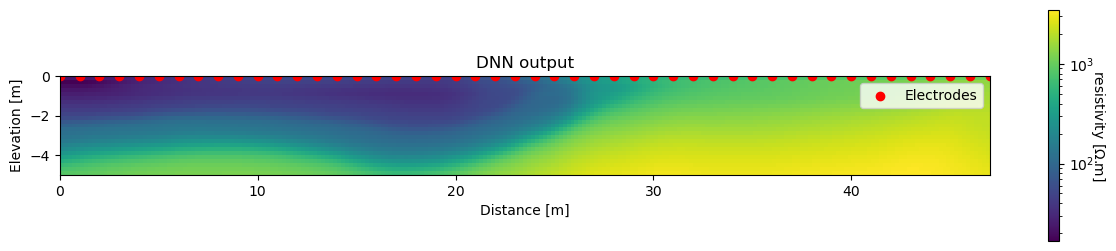

3481.7021
16.65965


In [90]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(15, 3))
max_v = np.max(o)
min_v = np.min(o)
norm = LogNorm(vmin=min_v, vmax=max_v)
extent = [0, 47, -depth_m, 0]

x_elec_ = (x_elec - 25) * px_to_m
plt.scatter(x_elec_, y_elec, c="red", marker="o", label="Electrodes")
plt.imshow(o[:, 25:W-25], cmap="viridis", extent=extent, norm=norm)
clb = plt.colorbar()
clb.set_label(r"resistivity [$\Omega$.m]", rotation=270, labelpad=9)
plt.title("DNN output")
plt.xlabel("Distance [m]")
plt.ylabel("Elevation [m]")
plt.legend()
plt.show()
print(max_v)
print(min_v)